In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import os

import numpy.typing as npt
from typing import Tuple

plt.style.use(['science', 'ieee', 'no-latex'])

In [2]:
NA = 0.86
LAMBDA = 248
K = 2 * np.pi / LAMBDA
W = NA / LAMBDA
THRESHOLD = 0.5

target_path = './img_test/dense_line'
if not os.path.isdir(target_path):
    os.makedirs(target_path)

In [3]:
def generate_Ein(
    s: npt.NDArray,
    angle: int = 0,
    magnitude: int = 1
) -> npt.NDArray:
    angle = angle / 180 * np.pi
    return magnitude * np.exp(1j * K * s * np.sin(angle))

In [4]:
def freq_and_Eoutshift(
    s: npt.NDArray,
    E_out_unshift: npt.NDArray,
    Fs: int
) -> Tuple[npt.NDArray, npt.NDArray]:
    N = (np.shape(s)[0] - 1) // 2
    freq = Fs * np.arange(-N, N + 1) / (2 * N)
    E_out_shift = np.concatenate((E_out_unshift[N + 1:], E_out_unshift[:N + 1]))
    return freq, E_out_shift

In [5]:
# sampling rate
Fs_dense = 2000
# dense line space
s_dense_space = 25200
s_dense_width = 100
s_dense: npt.NDArray = np.linspace(
    -s_dense_space, s_dense_space,
    2 * s_dense_space * Fs_dense + 1,
    dtype=np.double
)
s_dense_mask = np.zeros_like(s_dense, dtype=np.double)
points = range(0, s_dense_space, 4 * s_dense_width)
for center in points:
    cond = np.abs(s_dense - center) <= s_dense_width
    s_dense_mask[cond] = 1
    cond = np.abs(s_dense + center) <= s_dense_width
    s_dense_mask[cond] = 1

/tmp/ipykernel_211850/3334245761.py:107: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{target_path}/dense_line_aerial_{(angle // 20) + 1}.png')


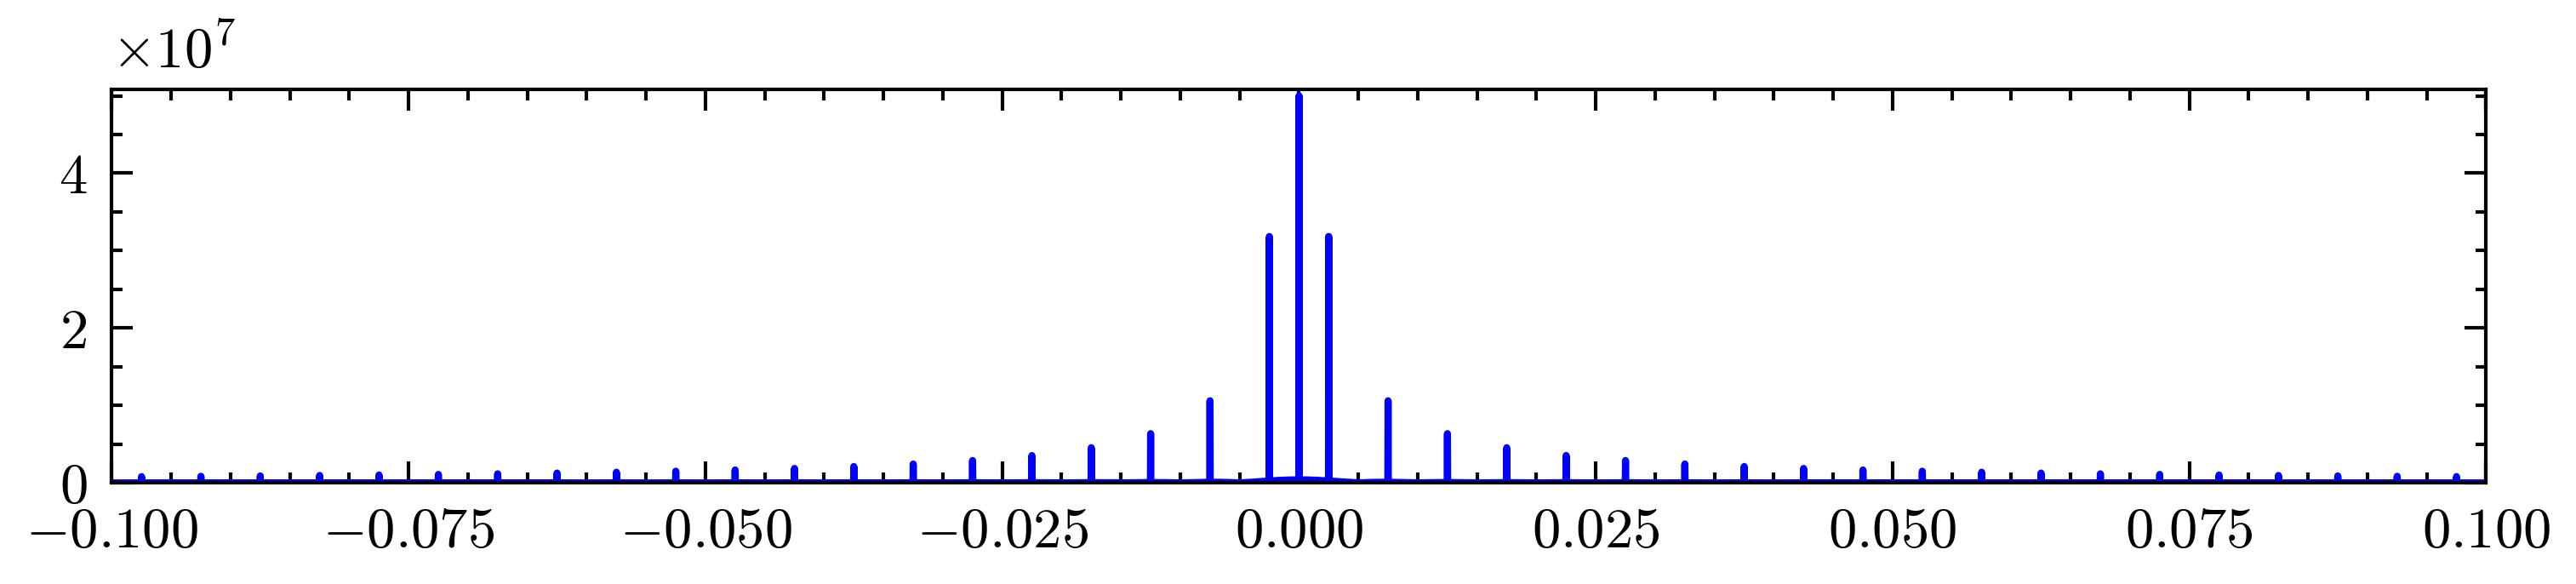

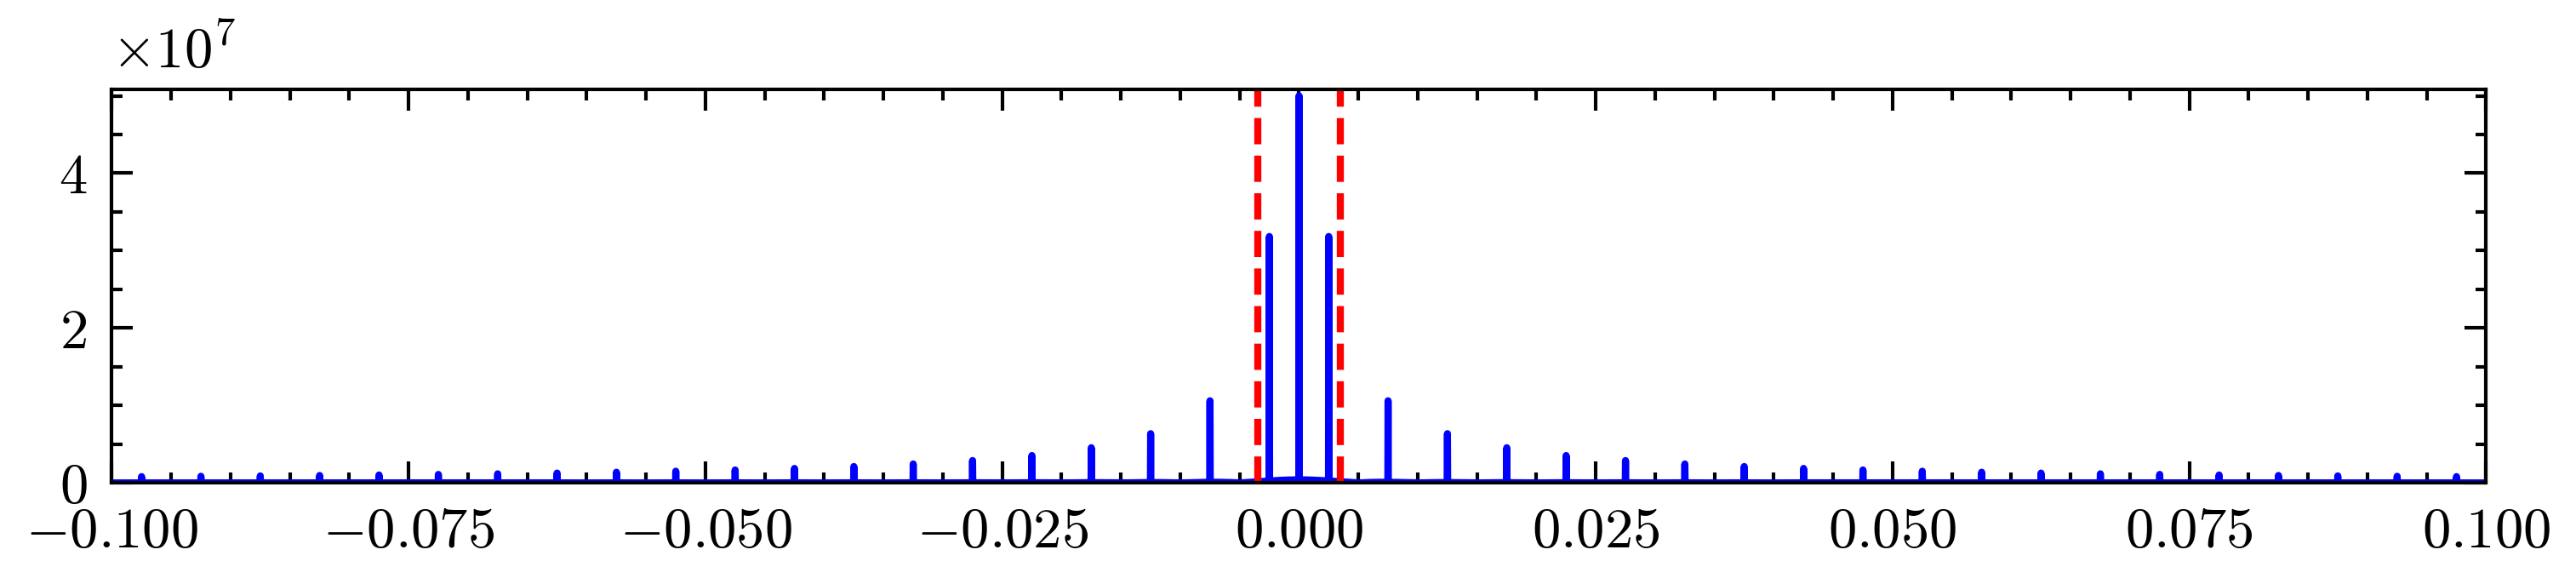

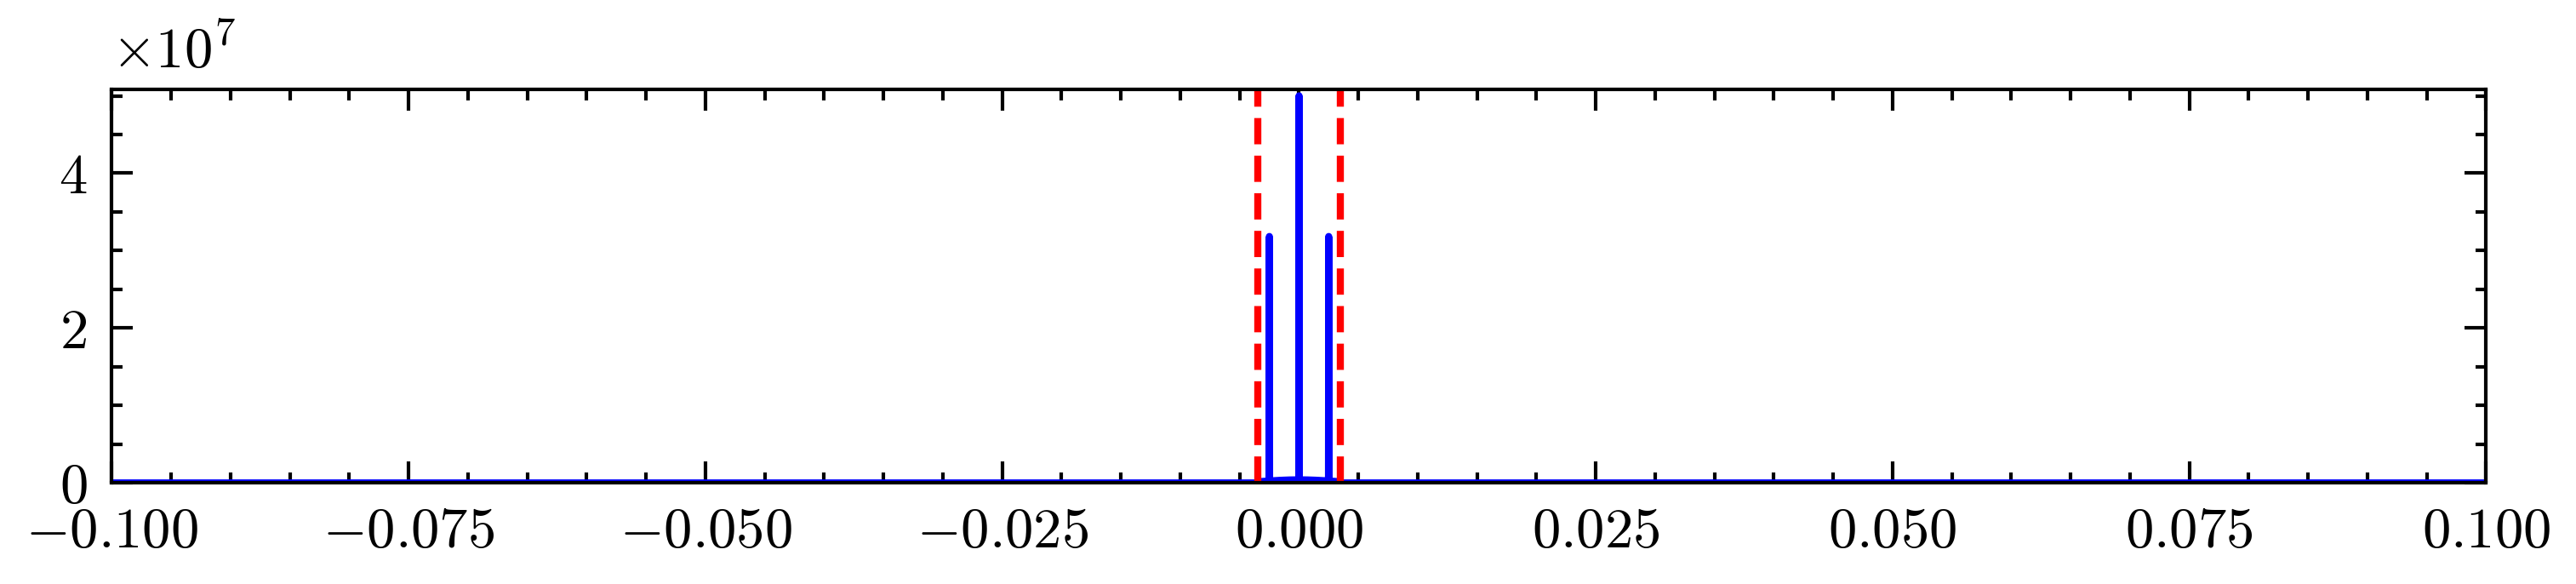

/home/louis/anaconda3/envs/sim/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


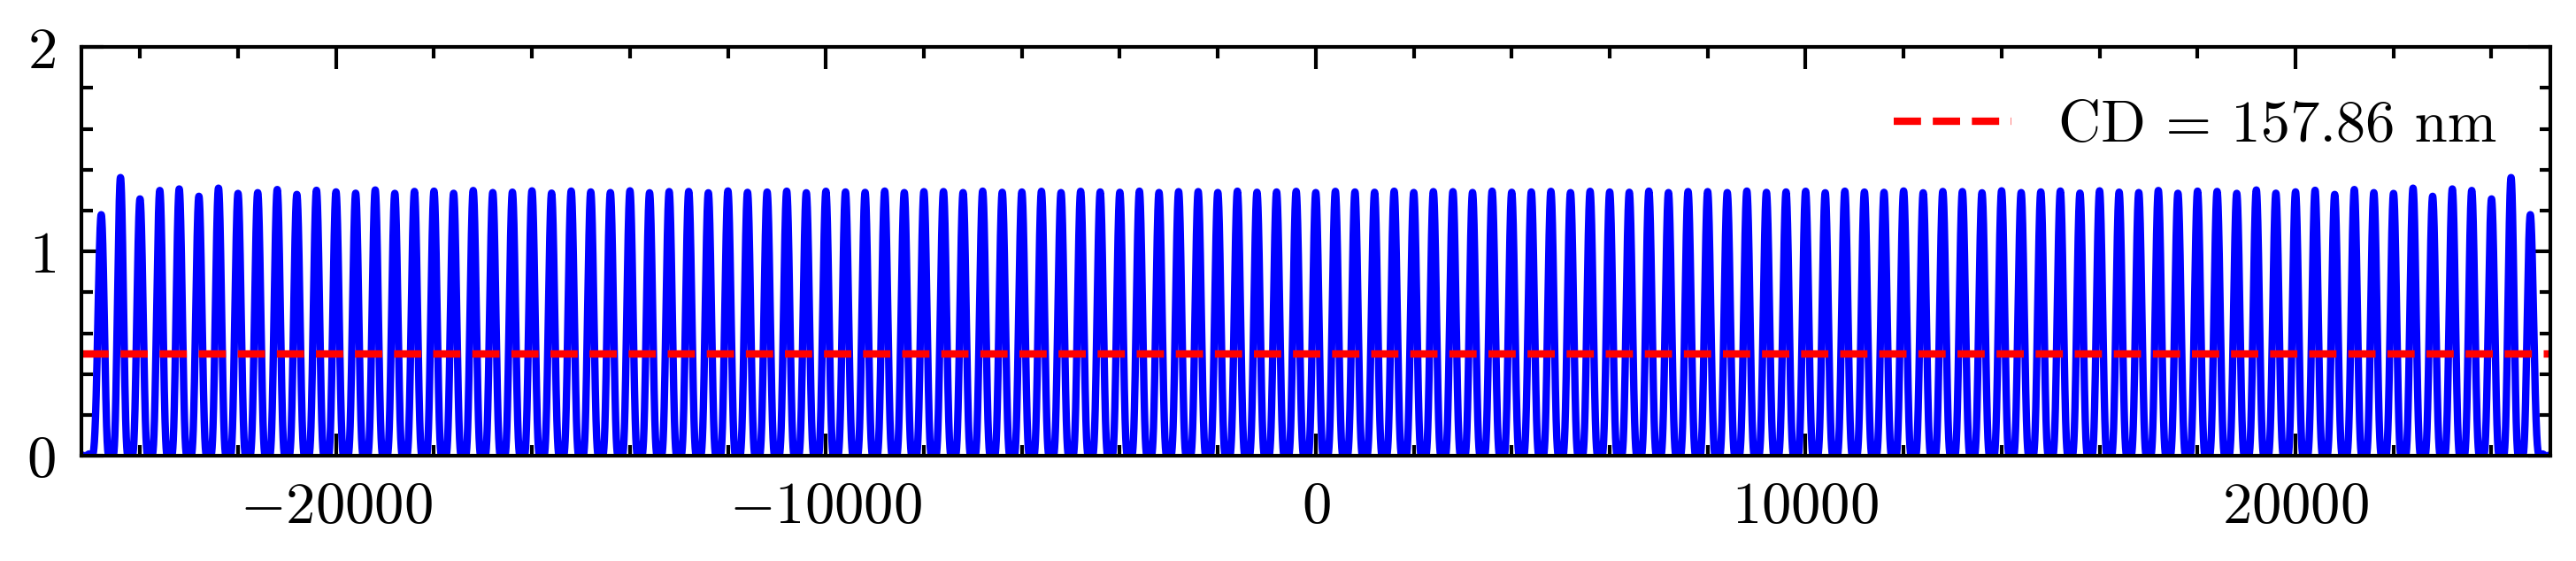

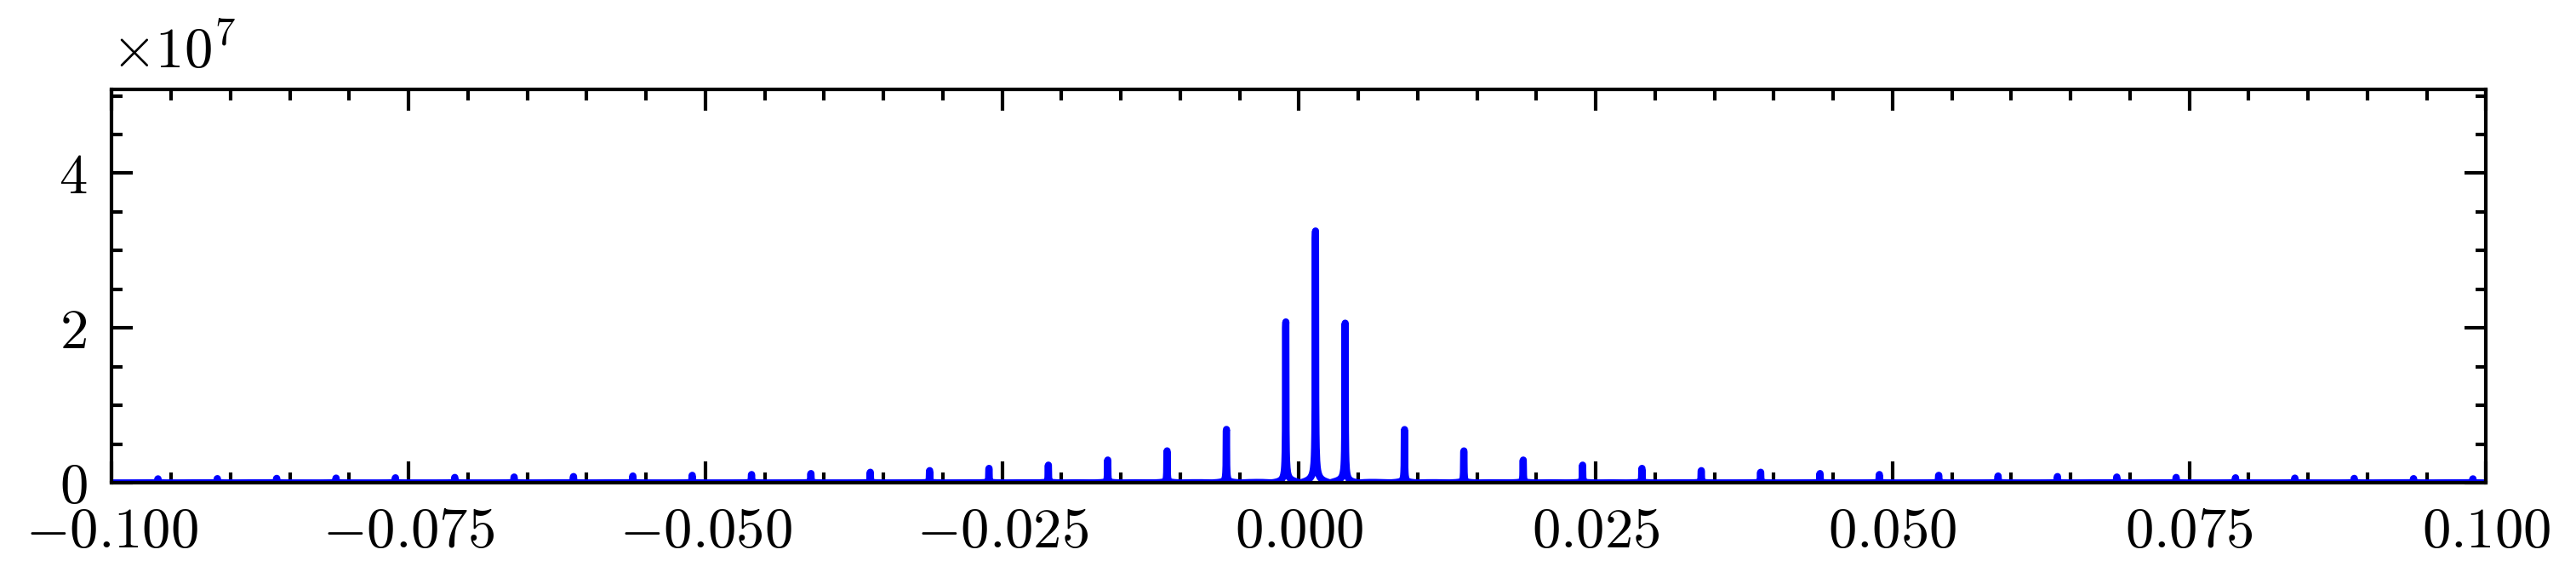

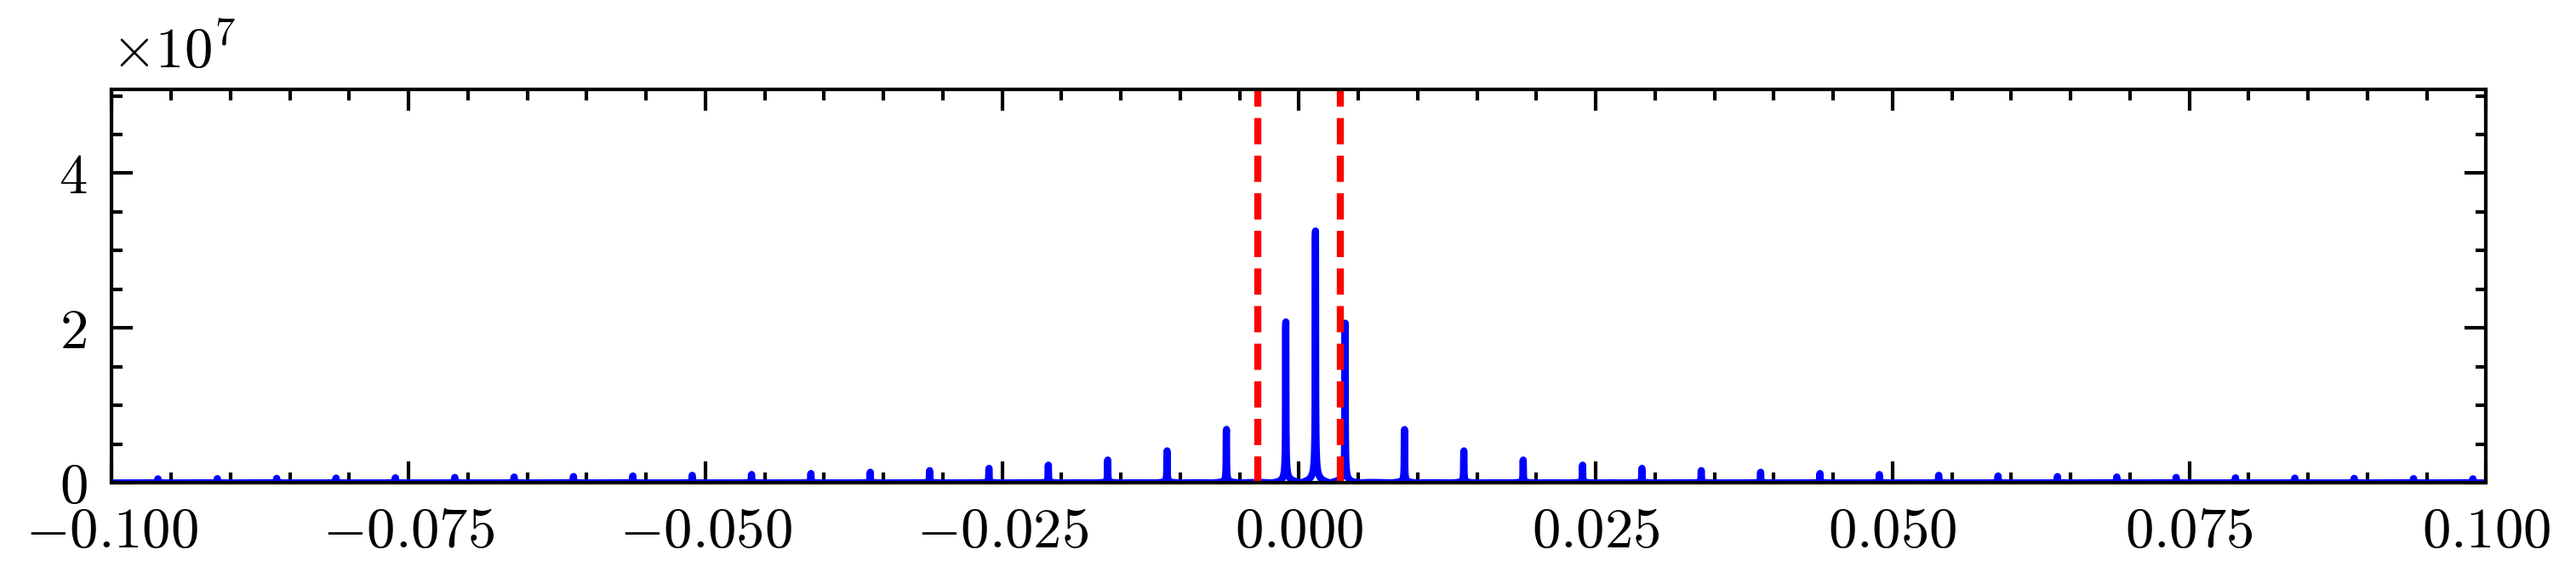

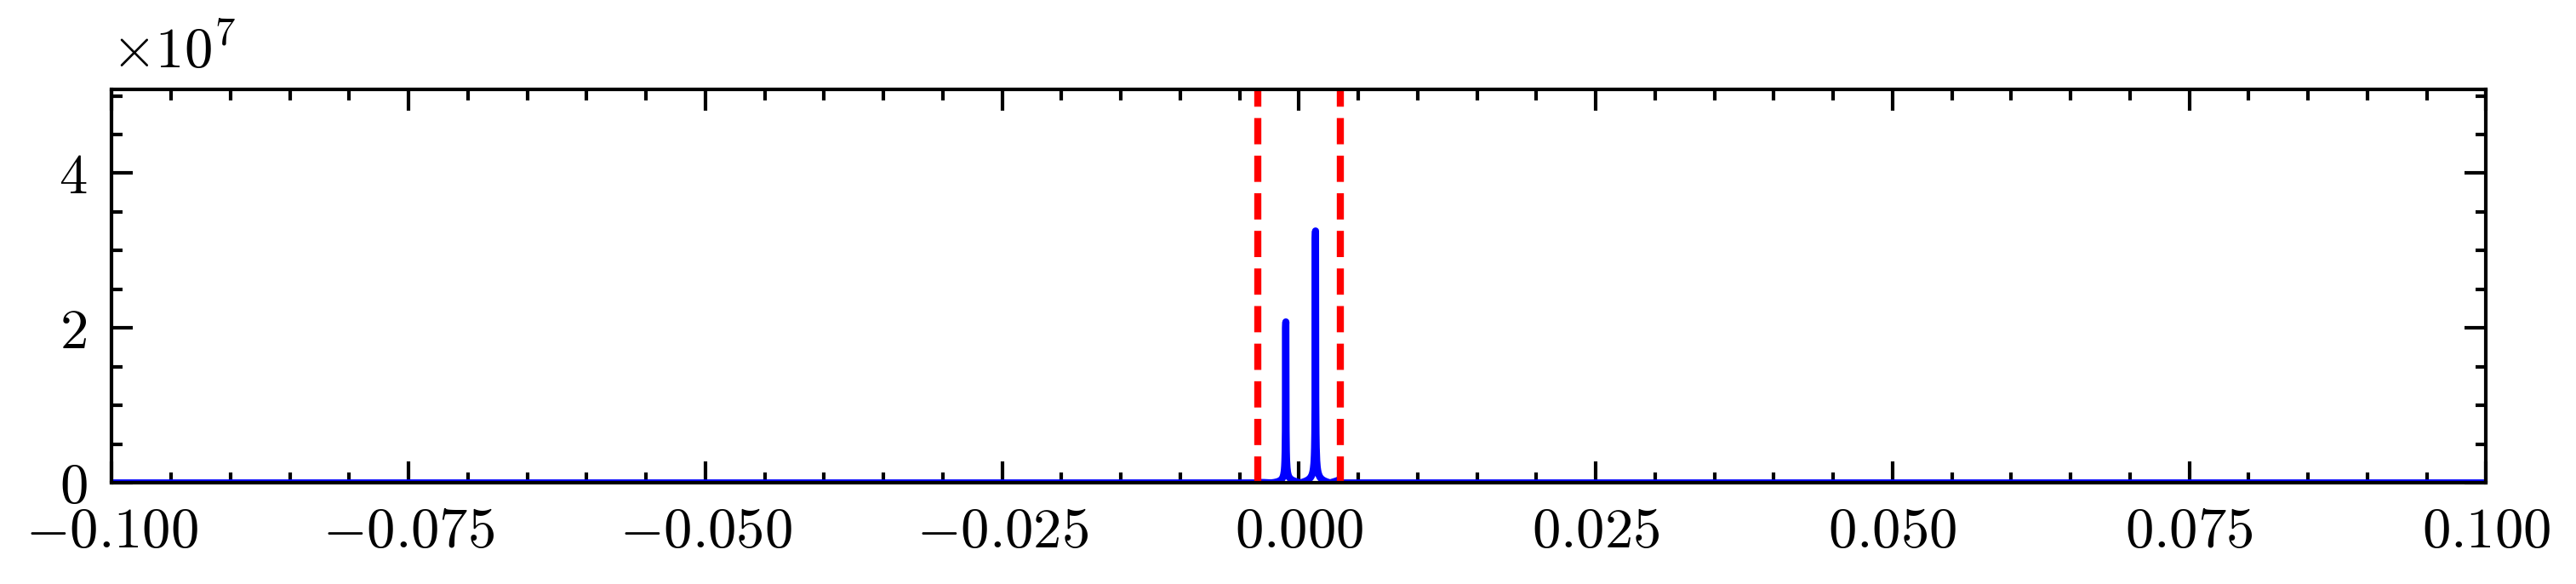

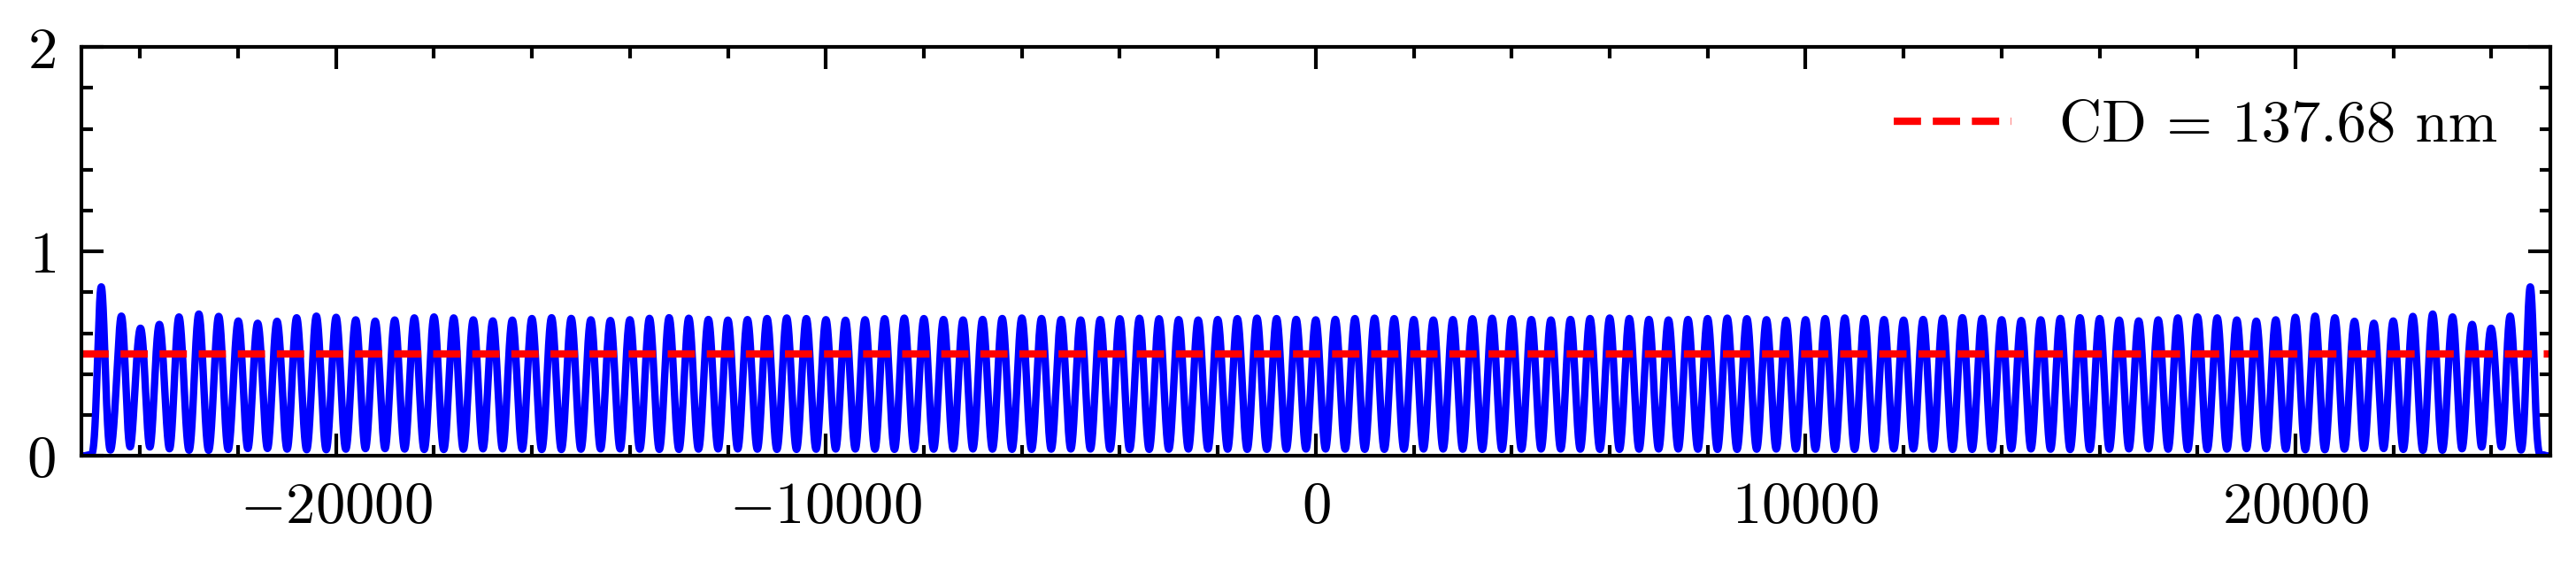

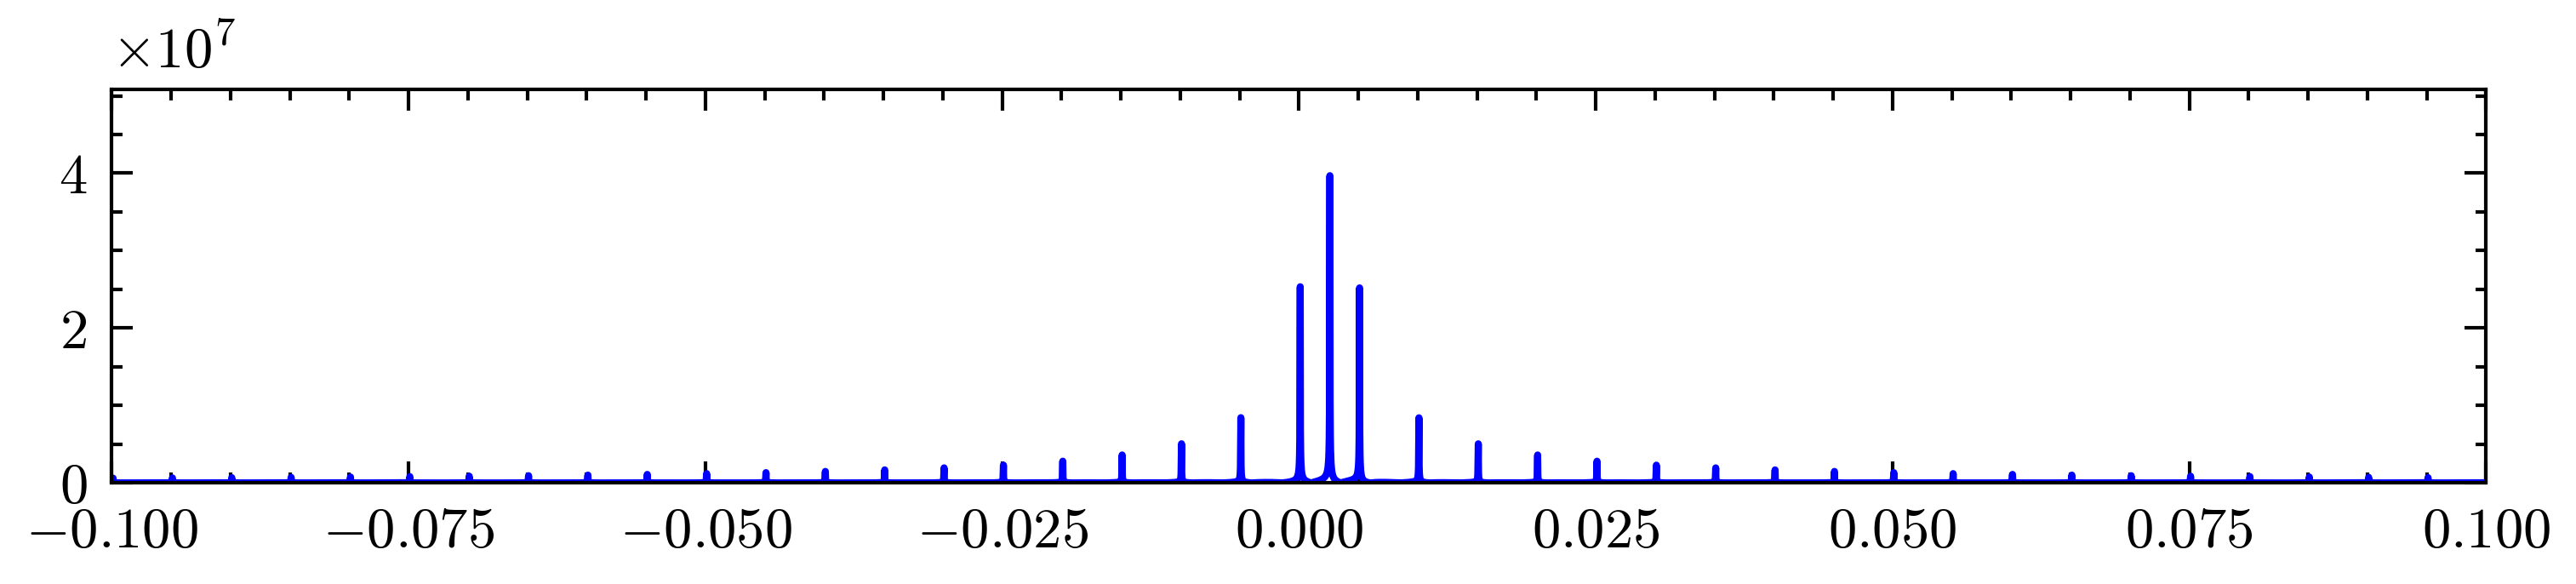

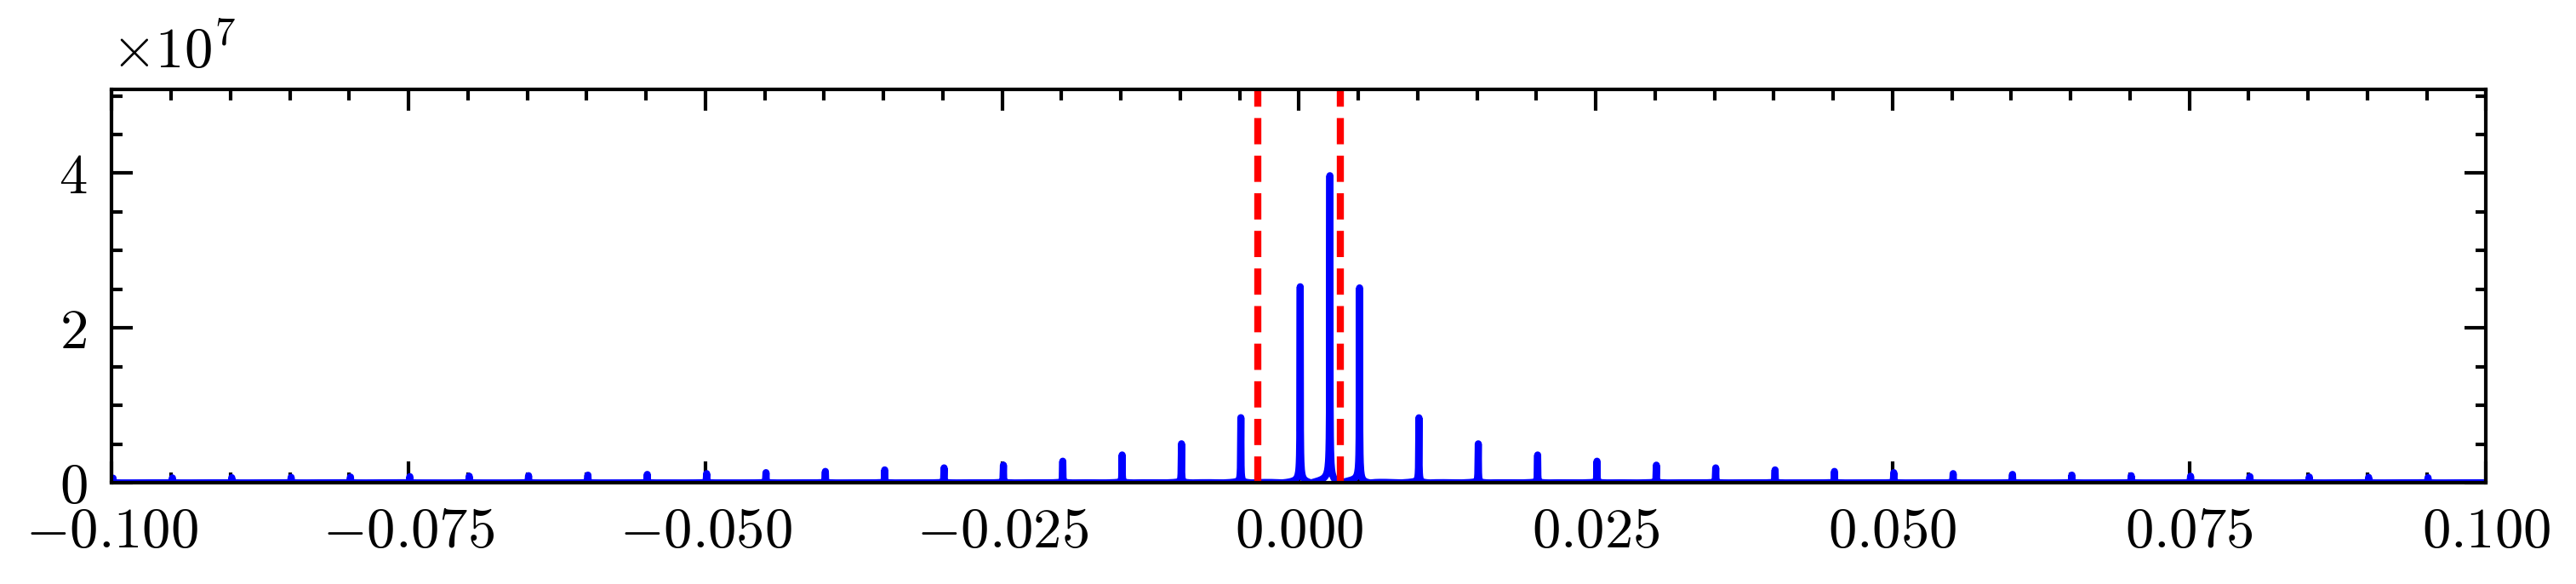

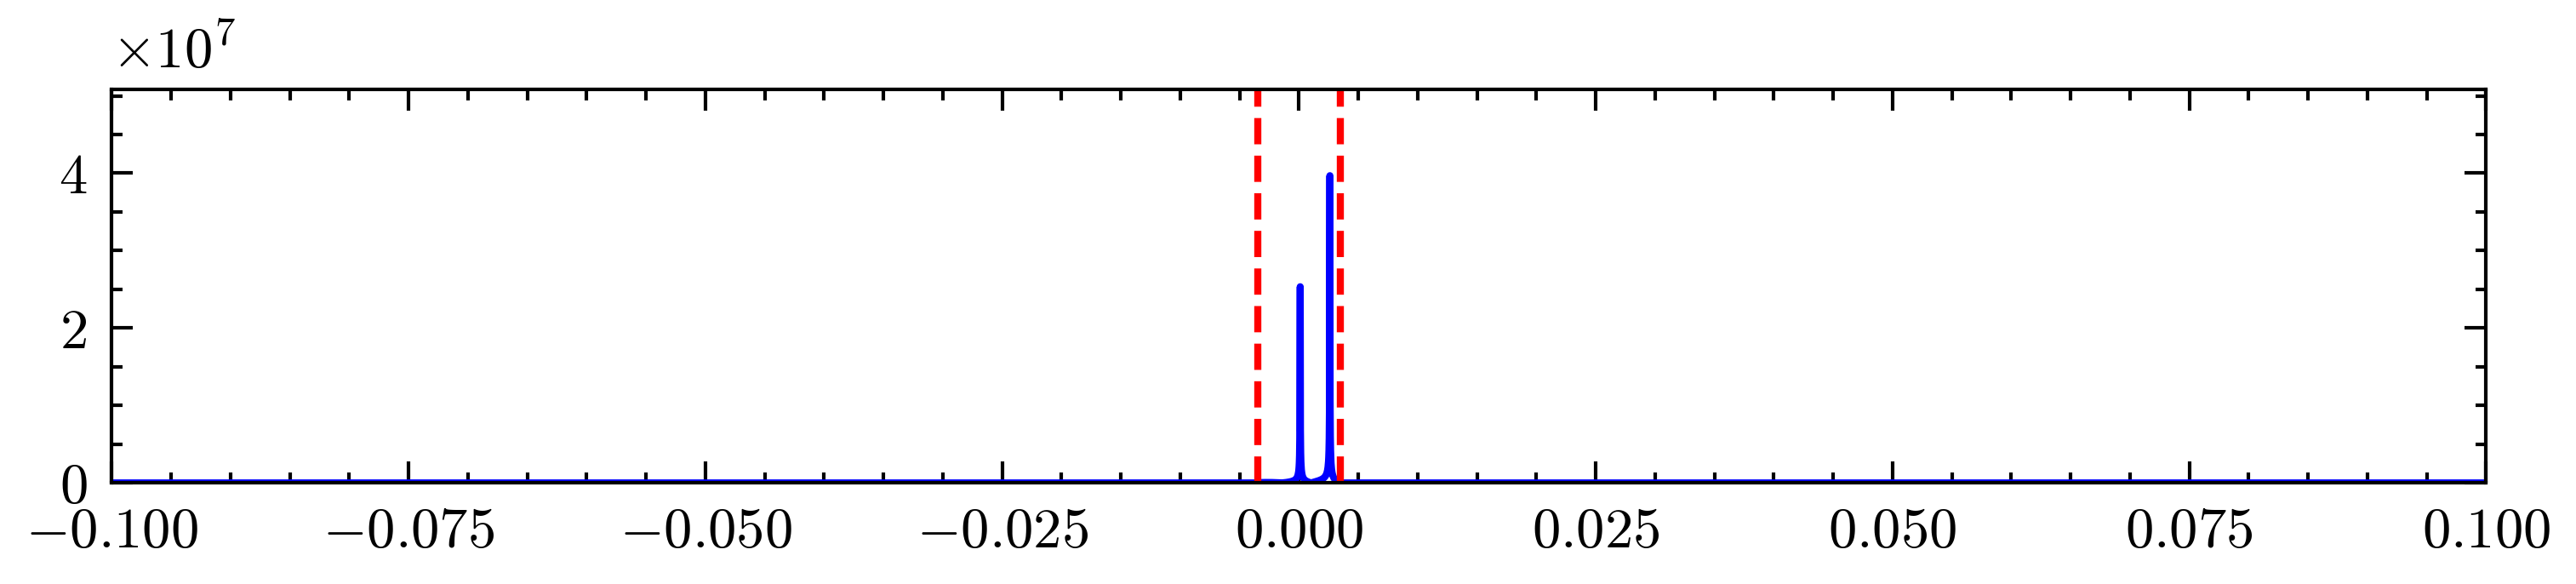

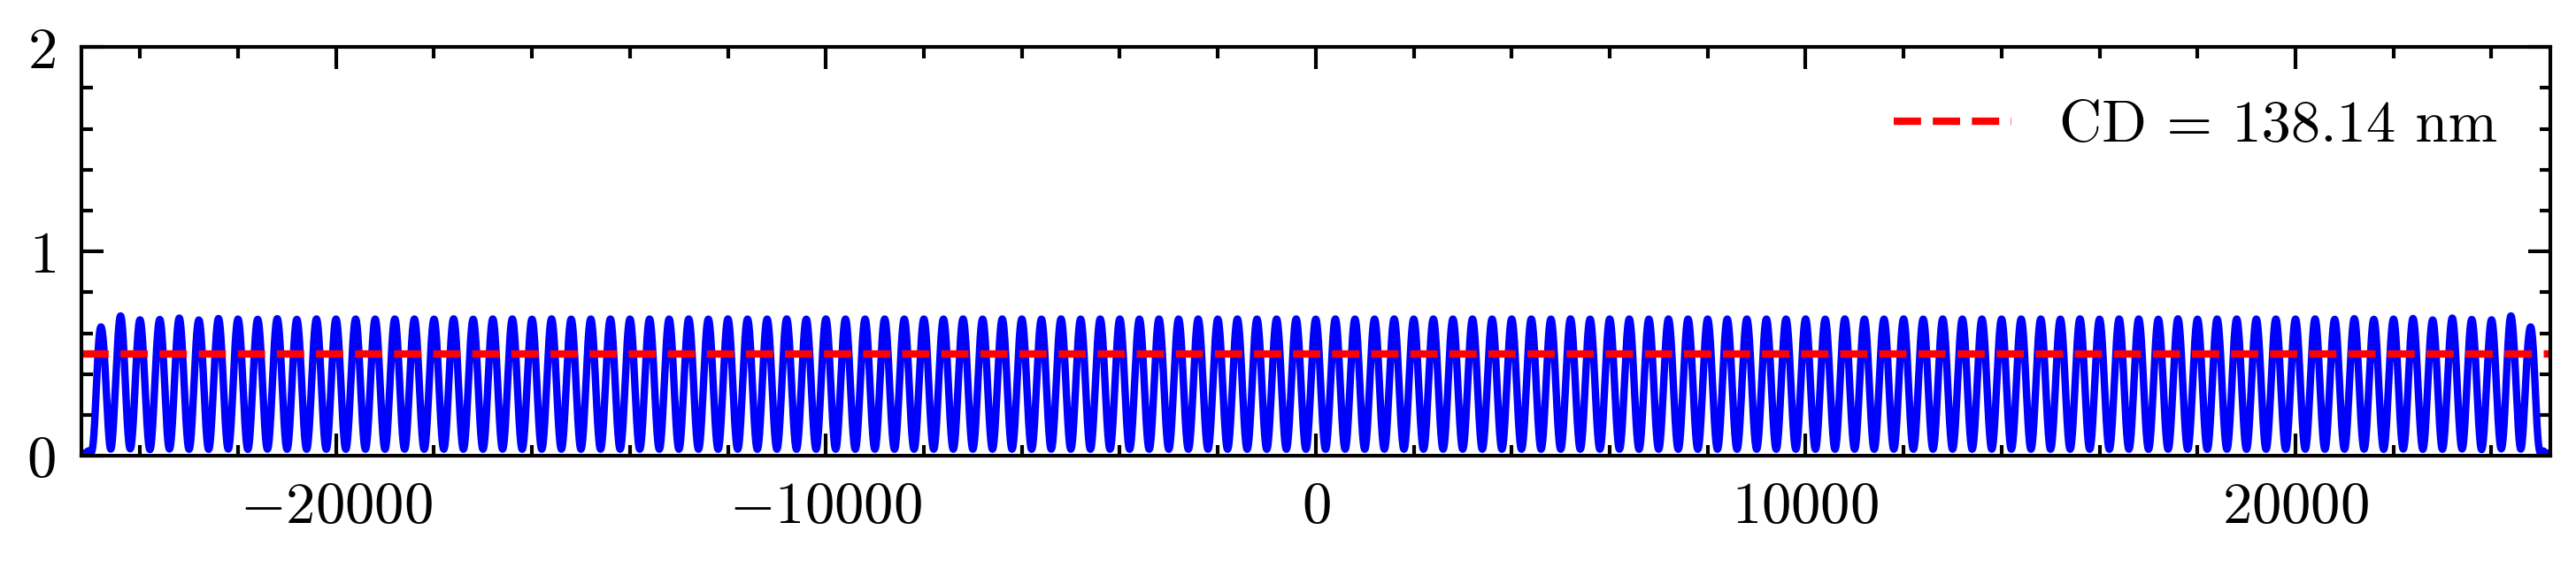

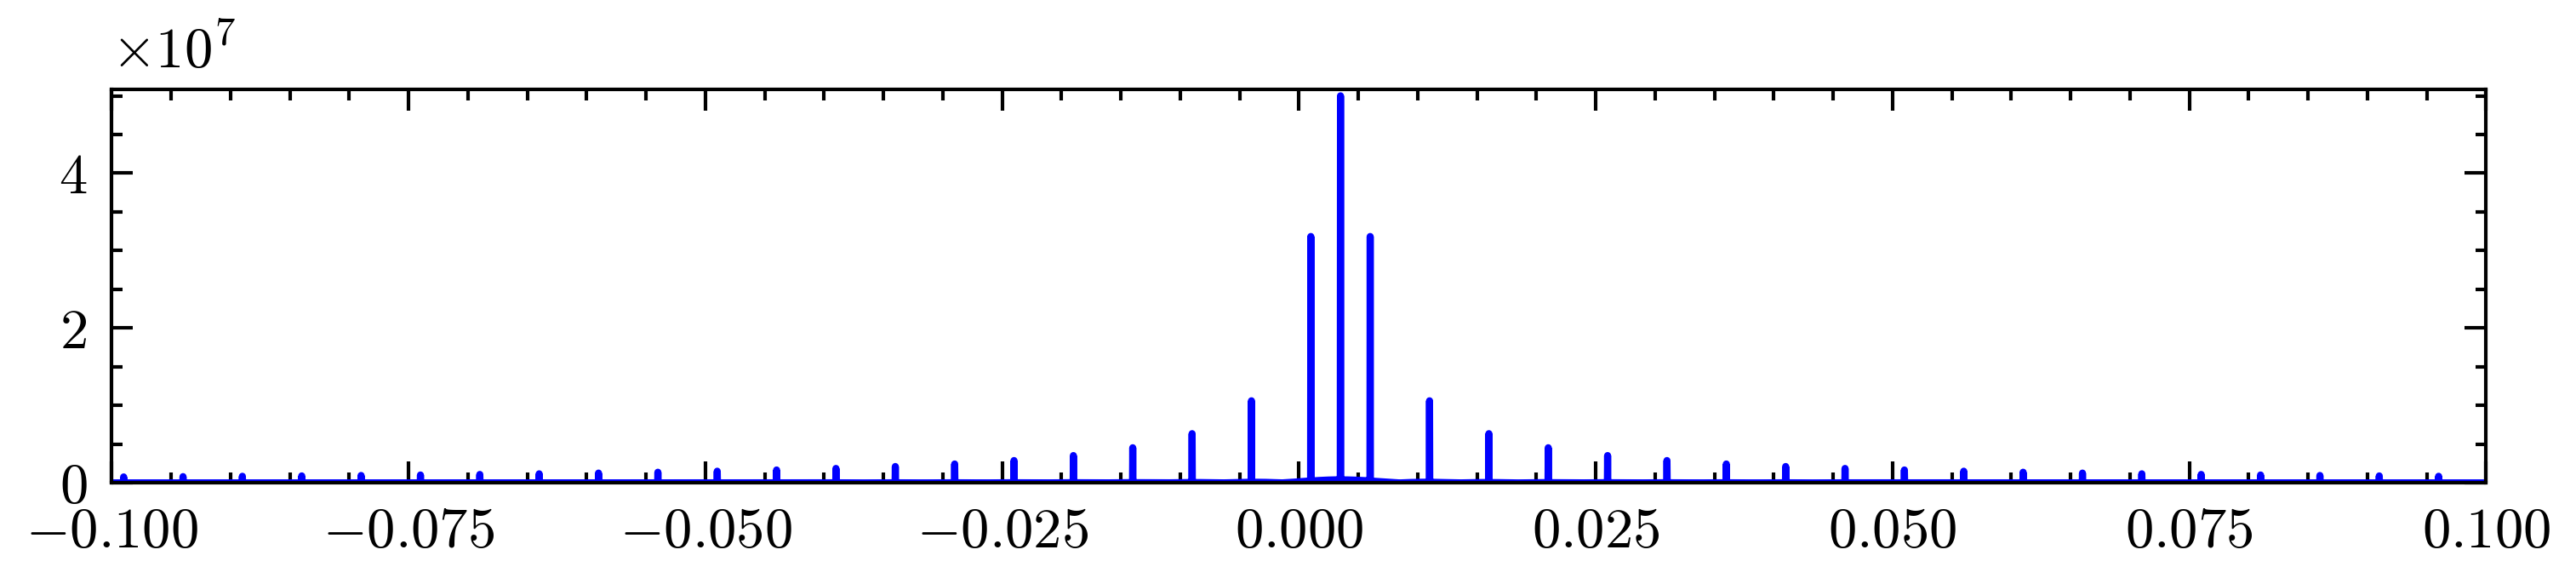

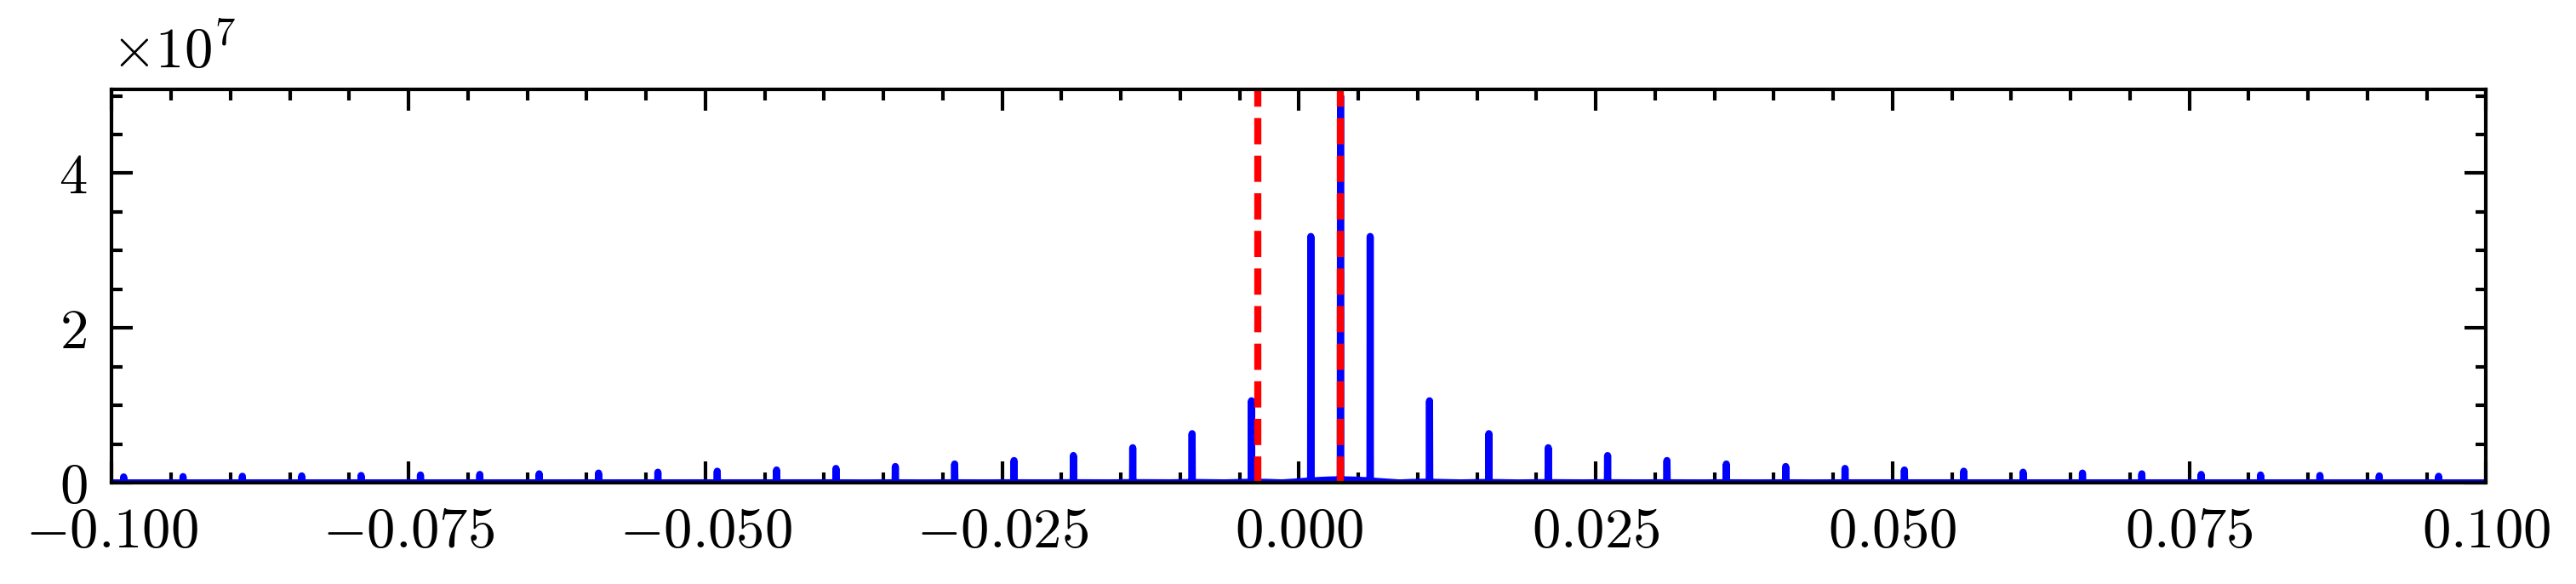

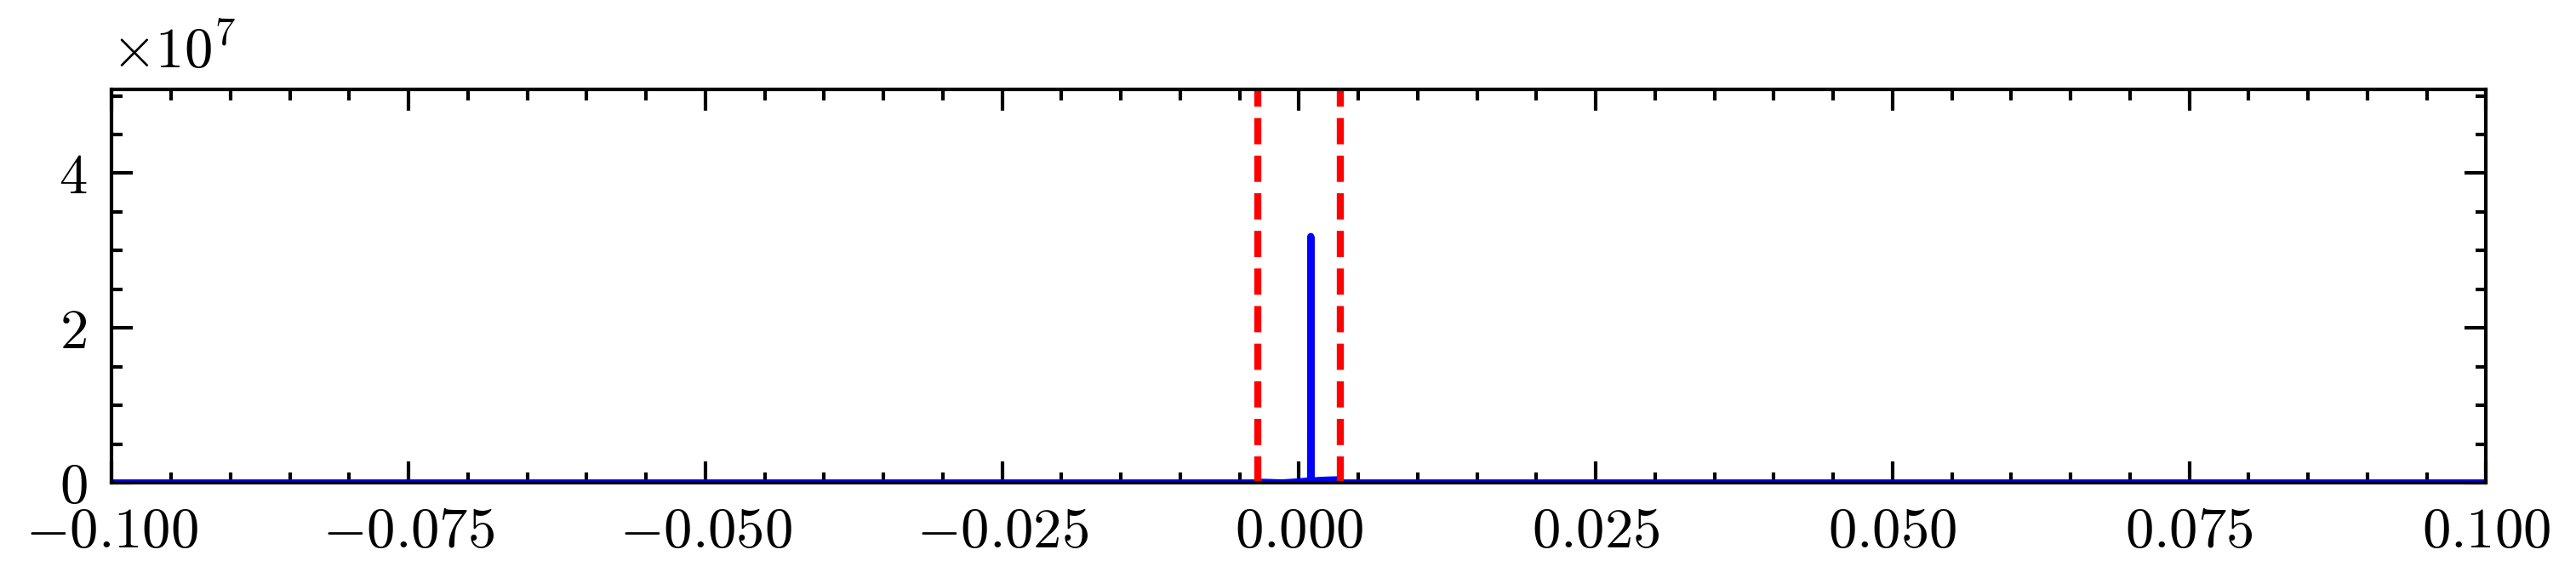

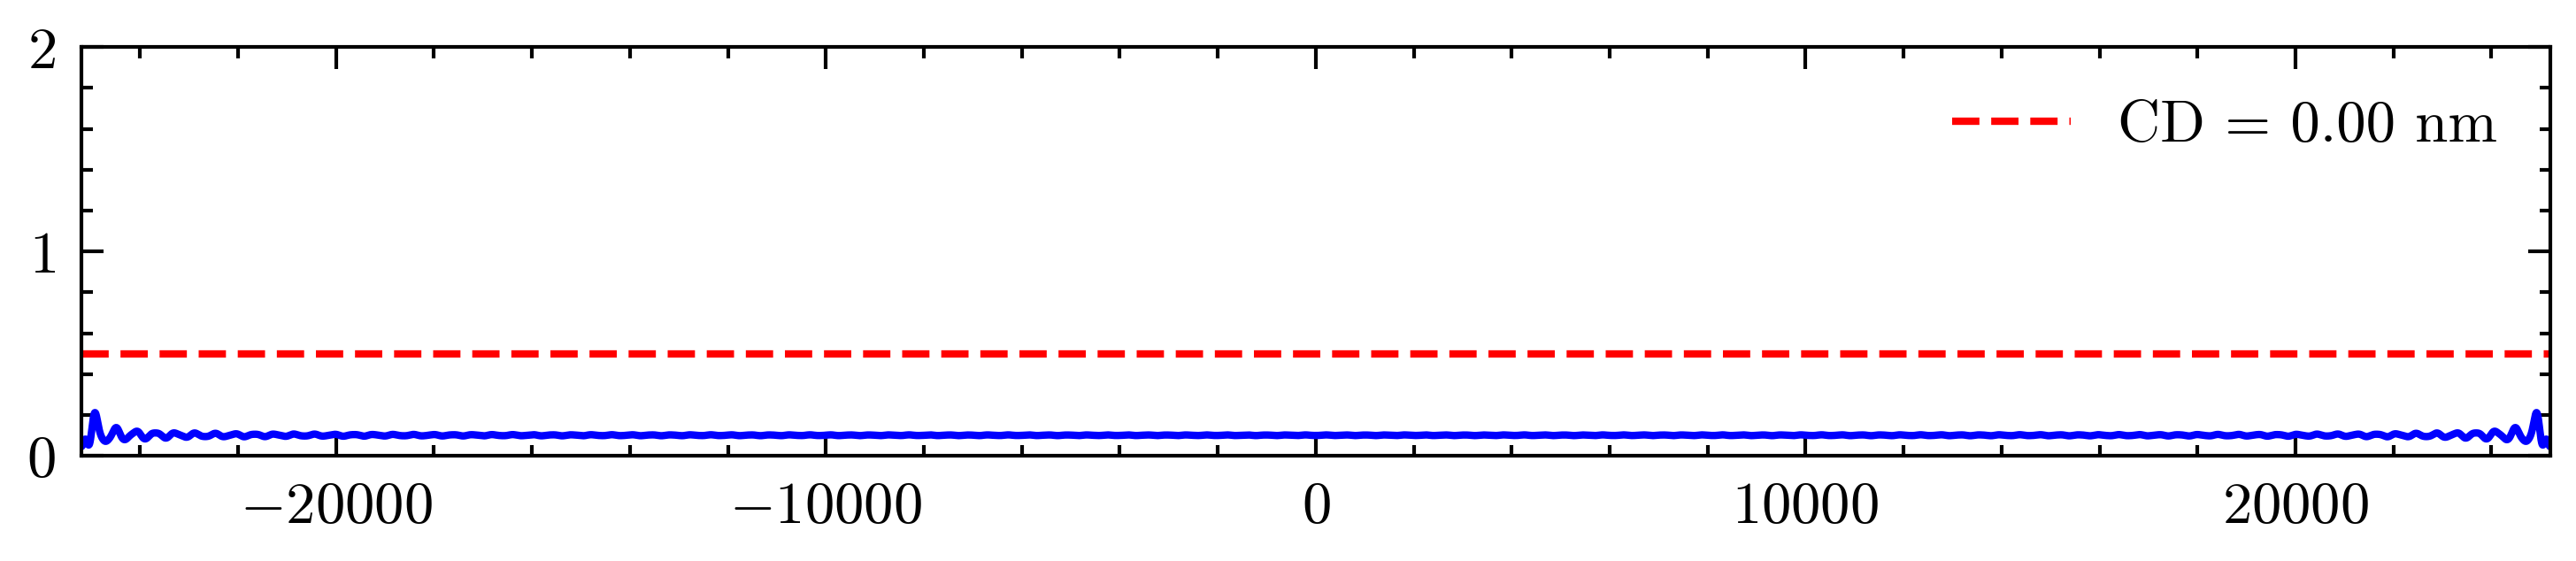

In [6]:
thetas = [0, 20, 40, 60]
magnitude = 1
y_max = (s_dense_space // 200 + 1) * 2 * s_dense_width * Fs_dense * magnitude
for angle in thetas:
    # generate Ein
    E_in = generate_Ein(s_dense, angle, magnitude)
    # Ein and the mask
    E_in_mask = np.multiply(E_in, s_dense_mask)
    # generate Eout
    E_out_unshift = np.fft.fft(E_in_mask)
    # get freq, Eout
    freq, E_out_shift = freq_and_Eoutshift(
        s_dense,
        E_out_unshift,
        Fs_dense
    )

    # condition specified frequency region
    cond = np.abs(freq) <= 0.1
    # plot the frequency to E_out_shift
    plt.figure(figsize=(6, 1))
    plt.xlim(-0.1, 0.1)
    plt.ylim(0, y_max)
    plt.ticklabel_format(
        axis='y', 
        style='sci', 
        scilimits=(7, 7)
    )
    plt.plot(freq[cond], np.abs(E_out_shift[cond]), 'b-')
    plt.savefig(f'{target_path}/dense_line_FT_{(angle // 20) + 1}.png')

    # plot the cut-off region before exit pupil
    plt.figure(figsize=(6, 1))
    plt.xlim(-0.1, 0.1)
    plt.ylim(0, y_max)
    plt.ticklabel_format(
        axis='y', 
        style='sci', 
        scilimits=(7, 7)
    )
    plt.plot(freq[cond], np.abs(E_out_shift[cond]), 'b-')
    plt.axvline(
        x=-W, 
        ymin=0, 
        ymax=y_max, 
        color='r', 
        linestyle='--'
    )
    plt.axvline(
        x=W, 
        ymin=0, 
        ymax=y_max, 
        color='r', 
        linestyle='--'
    )
    plt.savefig(f'{target_path}/dense_line_FT_cutoff_{(angle // 20) + 1}.png')

    # after exit pupil
    E_out_shift_after_exit_pupil = np.where(
        np.abs(freq) <= W, E_out_shift, 0
    )
    # plot the cut-off region after exit pupil
    plt.figure(figsize=(6, 1))
    plt.xlim(-0.1, 0.1)
    plt.ylim(0, y_max)
    plt.ticklabel_format(
        axis='y', 
        style='sci', 
        scilimits=(7, 7)
    )
    plt.plot(freq[cond], np.abs(E_out_shift_after_exit_pupil[cond]), 'b-')
    plt.axvline(
        x=-W, 
        ymin=0, 
        ymax=y_max, 
        color='r', 
        linestyle='--'
    )
    plt.axvline(
        x=W, 
        ymin=0, 
        ymax=y_max, 
        color='r', 
        linestyle='--'
    )
    plt.savefig(f'{target_path}/dense_line_cutoff_{(angle // 20) + 1}.png')

    # plot the aerial image
    E_output = np.fft.ifft(E_out_shift_after_exit_pupil)
    I = np.multiply(np.abs(E_output), np.abs(E_output))
    try:
        positive = s_dense[s_dense > 0]
        I_positive = I[s_dense > 0]
        freq_right = np.min(positive[I_positive < THRESHOLD])
        negative = s_dense[s_dense < 0]
        I_negative = I[s_dense < 0]
        freq_left = np.max(negative[I_negative < THRESHOLD])
        CD = freq_right - freq_left
    except ValueError:
        CD = 0
    plt.figure(figsize=(6, 1))
    plt.xlim(-s_dense_space, s_dense_space)
    plt.ylim(0, 2)
    plt.plot(s_dense, I, 'b-')
    plt.axhline(THRESHOLD, color='r', linestyle='--', label=f'CD = {CD:.2f} nm')
    plt.legend()
    plt.savefig(f'{target_path}/dense_line_aerial_{(angle // 20) + 1}.png')